# Proyek Klasifikasi Gambar: Grape_disease
- **Nama:** Irfan Nur Fahrudin
- **Email:** irfan.nurfahrudin@gmail.com
- **ID Dicoding:** inurart

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 23.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successful

In [1]:
import tensorflow as tf
import numpy as np
from google.colab import files
import shutil
import os
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import tensorflowjs as tfjs
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import Callback


In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)
print(tfjs.__version__)

2.19.0
4.22.0


## Data Preparation

### Data Loading

In [12]:
from google.colab import files
files.upload()  # Ini akan meminta upload file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"inurart","key":"02e579ba07ddef9231d4fa9401f04e8c"}'}

In [13]:
# Buat folder kaggle di home
os.makedirs("/root/.kaggle", exist_ok=True)

# Pindahkan kaggle.json ke folder yang benar
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permission agar bisa digunakan
os.chmod("/root/.kaggle/kaggle.json", 600)

In [5]:
!kaggle datasets download -d pushpalama/grape-disease

Dataset URL: https://www.kaggle.com/datasets/pushpalama/grape-disease
License(s): unknown
100% 151M/151M [00:01<00:00, 144MB/s]
100% 151M/151M [00:01<00:00, 121MB/s]


In [10]:
with zipfile.ZipFile("grape-disease.zip", 'r') as zip_ref:
    zip_ref.extractall("grape_disease")  # Ekstrak ke folder "grape_disease"

In [9]:
print(os.listdir("/content/grape_disease/grape_dataset/test"))  # Lihat isi dataset

['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___Esca_(Black_Measles)', 'Grape___Black_rot', 'Grape___healthy']


### Gabungkan Data Train, Data Test, Data Validasi ke Direktori yang Sama

In [14]:
# Direktori awal untuk train dan test
train_dir = "/content/grape_disease/grape_dataset/train"
test_dir = "/content/grape_disease/grape_dataset/test"

# Direktori baru untuk dataset gabungan
combined_dir = "/content/combinerd-dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

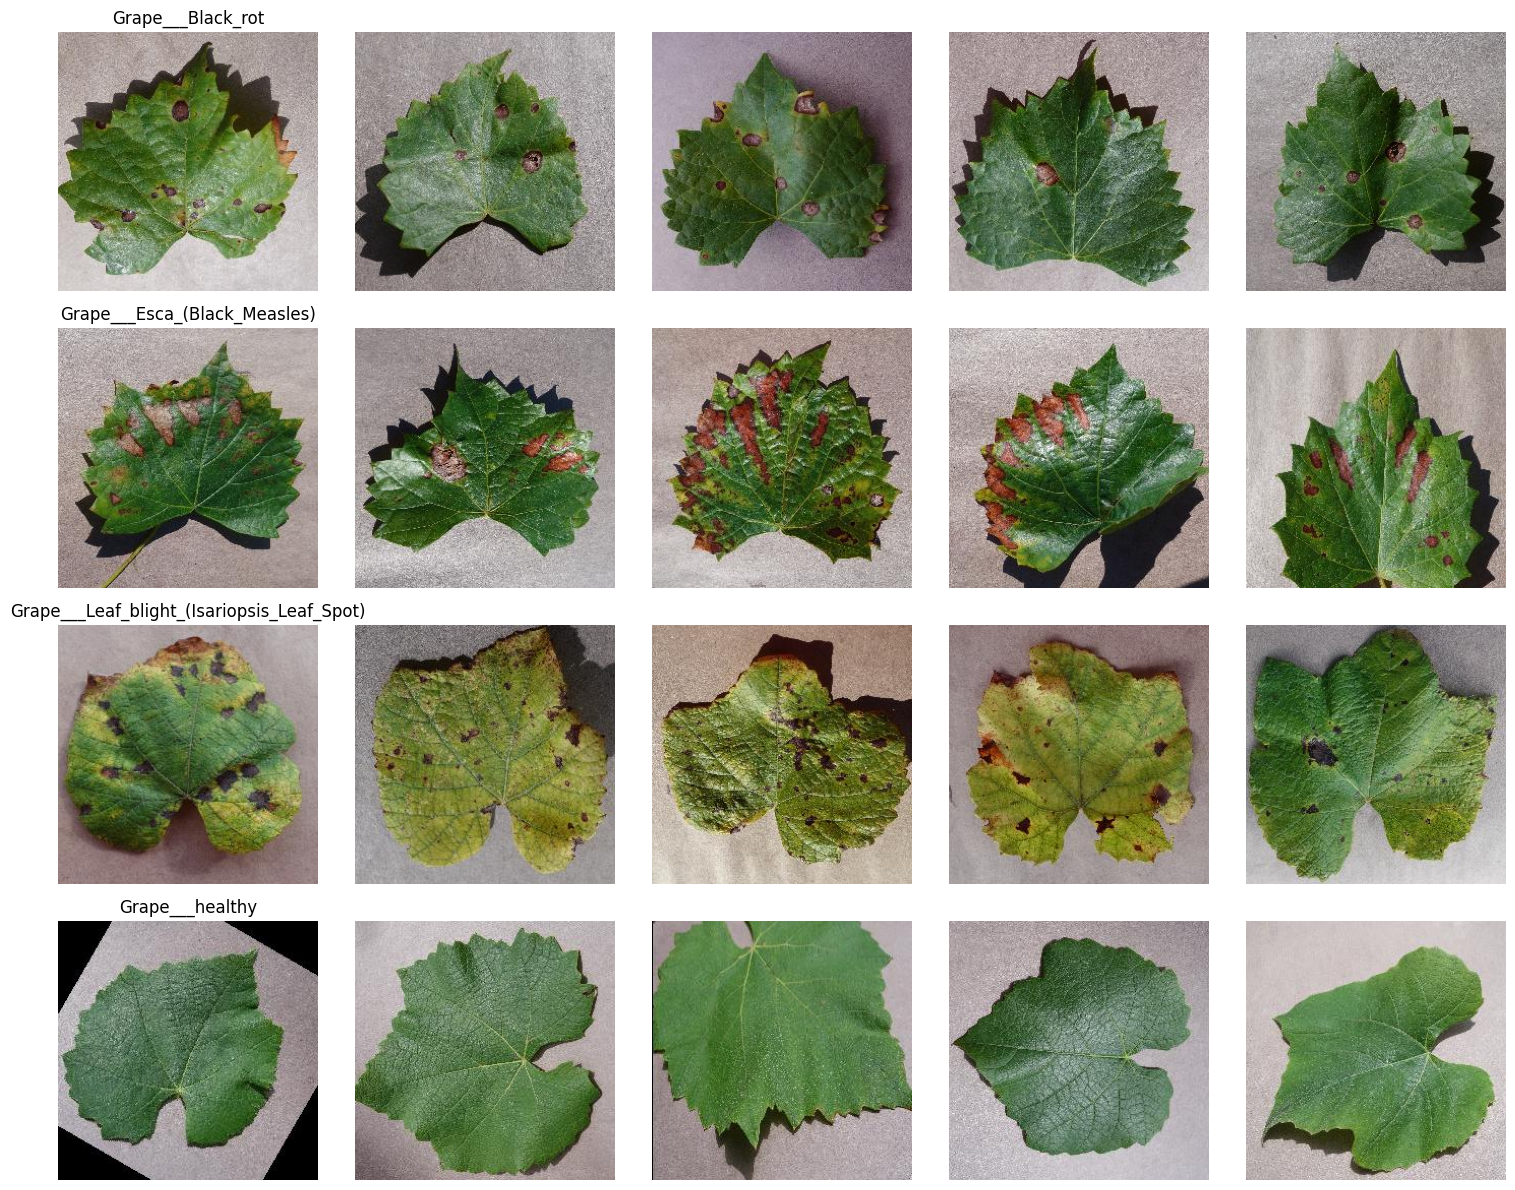

In [16]:
# Path dataset
dataset_path = "/content/combinerd-dataset" # Changed to the combined dataset directory

# Ambil daftar kelas (folder)
class_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])

# Menentukan jumlah kelas
num_classes = len(class_names)

# Membuat subplot dengan jumlah baris = jumlah kelas
fig, axs = plt.subplots(num_classes, 5, figsize=(15, num_classes * 3))

# Loop setiap kelas
for i, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))] # Get only files

    # Pilih 5 gambar secara acak (cek jika jumlah gambar lebih sedikit)
    sample_images = np.random.choice(images, min(5, len(images)), replace=False)

    # Loop untuk menampilkan gambar
    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)  # Buka gambar

        # Tampilkan gambar di subplot
        axs[i, j].imshow(img)
        axs[i, j].axis("off")  # Hilangkan axis
        axs[i, j].set_title(class_name if j == 0 else "")  # Hanya tampilkan nama kelas di gambar pertama

# Sesuaikan tata letak
plt.tight_layout()
plt.show()

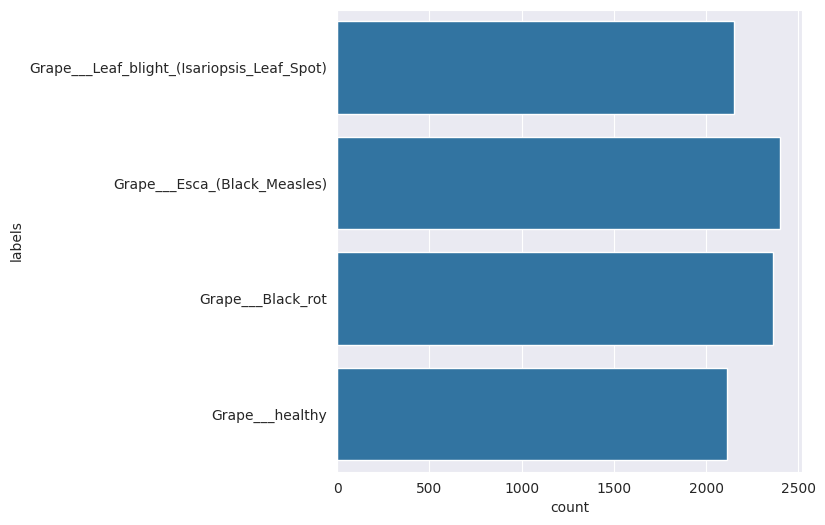

In [17]:
import pandas as pd
import seaborn as sns

# Define source path
lung_path = "/content/combinerd-dataset"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [18]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= '/content/combinerd-dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Grape___Black_rot,2360
Grape___Esca_(Black_Measles),2400
Grape___Leaf_blight_(Isariopsis_Leaf_Spot),2152
Grape___healthy,2115


In [19]:
# Direktori combined dataset
dataset_dir = '/content/combinerd-dataset'

# Direktori untuk menyimpan dataset yang dibagi
output_dir = 'splitted-dataset'
os.makedirs(output_dir, exist_ok=True)

# Persentase pembagian data
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Pastikan rasio pembagian berjumlah 1
assert train_ratio + val_ratio + test_ratio == 1

# Daftar semua subdirektori (kelas)
classes = os.listdir(dataset_dir)

for cls in classes:
    # Path untuk setiap kelas
    class_path = os.path.join(dataset_dir, cls)

    # Dapatkan daftar semua file gambar dalam kelas
    images = os.listdir(class_path)

    # Bagi data menjadi set pelatihan dan set sementara (gabungan validasi dan pengujian)
    train_images, temp_images = train_test_split(images, test_size=(1 - train_ratio), random_state=42)

    # Bagi set sementara menjadi set validasi dan set pengujian
    val_images, test_images = train_test_split(temp_images, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

    # Buat direktori untuk set pelatihan, validasi, dan pengujian
    train_dir = os.path.join(output_dir, 'train', cls)
    val_dir = os.path.join(output_dir, 'val', cls)
    test_dir = os.path.join(output_dir, 'test', cls)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Salin gambar ke direktori masing-masing
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, img)
        shutil.copyfile(src, dst)

    for img in val_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_dir, img)
        shutil.copyfile(src, dst)

    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, img)
        shutil.copyfile(src, dst)

print("Dataset berhasil dibagi!")

Dataset berhasil dibagi!


## Modelling

### Sequential

In [20]:
# Inisialisasi parameter
img_size = 150
batch_size = 32
epochs = 50

# Direktori dataset
train_dir = '/content/splitted-dataset/train'
val_dir = '/content/splitted-dataset/val'
test_dir = '/content/splitted-dataset/test'


# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 6316 images belonging to 4 classes.
Found 1354 images belonging to 4 classes.
Found 1357 images belonging to 4 classes.


In [22]:
# Ukuran input gambar
img_height, img_width = 150, 150

# Membuat model Sequential
model = Sequential([
    # Layer Konvolusi 1
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2,2)),

    # Layer Konvolusi 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Layer Konvolusi 3
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Layer Flatten
    Flatten(),

    # Fully Connected Layer 1
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Fully Connected Layer 2 (Output Layer)
    Dense(4, activation='softmax')
])



# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary Model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,836,868 (18.45 MB)

 Trainable params: 4,836,868 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
train_dir = "/content/splitted-dataset/train"
val_dir = "/content/splitted-dataset/val"

class StopTrainingAtAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc is not None and val_acc is not None:
            if train_acc >= 0.98 and val_acc >= 0.98:  # Cek keduanya
                print(f"\n🎯 Epoch {epoch+1}: Akurasi training & validasi ≥ 98%! 🚀 Training dihentikan.")
                self.model.stop_training = True

# Inisialisasi callback
stop_callback = StopTrainingAtAccuracy()

# Training model dengan callback
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[stop_callback]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 59s 258ms/step - accuracy: 0.4615 - loss: 1.1651 - val_accuracy: 0.6108 - val_loss: 1.0646
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.7434 - loss: 0.6287 - val_accuracy: 0.7585 - val_loss: 0.6702
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - accuracy: 0.8258 - loss: 0.4744 - val_accuracy: 0.7459 - val_loss: 0.6774
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - accuracy: 0.8757 - loss: 0.3501 - val_accuracy: 0.9313 - val_loss: 0.2266
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 200ms/step - accuracy: 0.9073 - loss: 0.2718 - val_accuracy: 0.8235 - val_loss: 0.4630
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.9317 - loss: 0.2101 - val_accuracy: 0.8287 - val_loss: 0.5845
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 199ms/step - accuracy: 0.9396 - loss: 0.1897 - val_accuracy: 0.8826 - val_loss: 0.3072
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - accuracy: 0.9417 - loss: 0

## Evaluasi dan Visualisasi

In [24]:
# Evaluasi Model
test_loss, test_acc = model.evaluate(test_generator)

print(f"🎯 Akurasi Model pada Test Set: {test_acc * 100:.2f}%")


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9889 - loss: 0.0287
🎯 Akurasi Model pada Test Set: 98.67%


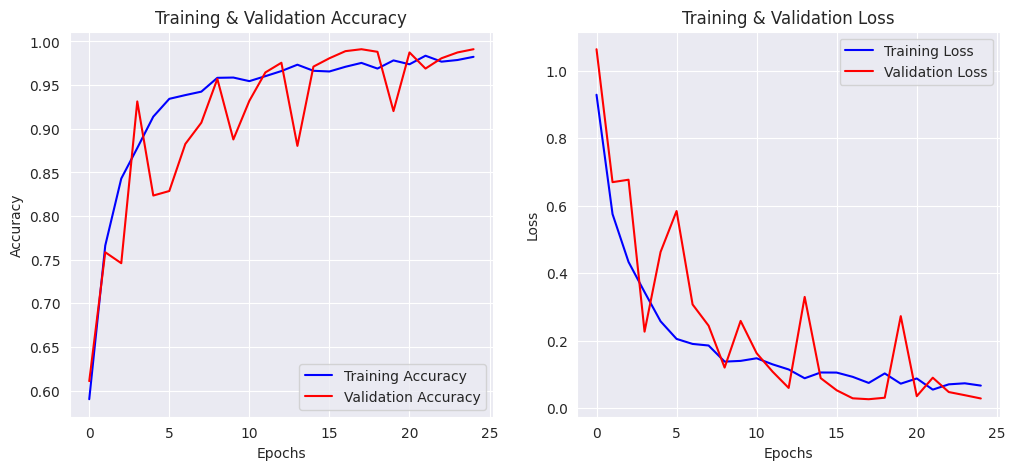

In [25]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Tambahkan ini setelah model.fit()


## Konversi Model

In [34]:
# Simpan model ke format SavedModel
save_path ='saved_model/'
tf.saved_model.save(model, save_path)

In [30]:
tfjs.converters.save_keras_model(model, "model_tfjs")

failed to lookup keras version from the file,
    this is likely a weight only file


In [33]:
# Buat folder 'tflite' jika belum ada
tflite_dir = "tflite"
os.makedirs(tflite_dir, exist_ok=True)

# Simpan model TFLite
tflite_model_path = os.path.join(tflite_dir, "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Simpan label.txt
label_path = os.path.join(tflite_dir, "label.txt")
class_labels = list(train_generator.class_indices.keys())  # Ambil label dari generator
with open(label_path, "w") as f:
    for label in class_labels:
        f.write(label + "\n")

In [42]:
# Kompres folder menjadi zip
shutil.make_archive('/content/tflite', 'zip', '/content/tflite')
shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')
shutil.make_archive('/content/model_tfjs', 'zip', '/content/model_tfjs')

# Mendownload model
files.download('/content/tflite.zip')
files.download('/content/saved_model.zip')
files.download('/content/model_tfjs.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)